<h1>Variational classifier - Parity Classification</h1>

This notebook is adapted from the [Pennylane tutorial](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html) on variational quantum classifiers. We show how to combine Pennylane's QML facilities with Covalent to learn the parity function

$$
f: x \in \{0, 1\}^n  \to \left\{\begin{array}{ll} 1, & x \text{ contains an odd number of 1's}\\
0, & x \text{ contains an even number of 1's.}\end{array}\right.
$$


First we install the required packages.

In [1]:
with open("./requirements.txt", "r") as file:
    for line in file:
        print(line.rstrip())


covalent
matplotlib==3.4.3
pennylane==0.25.1


In [2]:
# Install required packages
# !pip install -r ./requirements.txt


We import PennyLane, the PennyLane-provided version of NumPy, and an optimizer.

In [3]:
import pennylane as qml
from pennylane import numpy as np
import covalent as ct
import matplotlib.pyplot as plt
from pennylane.optimize import NesterovMomentumOptimizer


In [4]:
dev = qml.device("default.qubit", wires=4)


Variational classifiers usually define a “layer” or “block”, which is an elementary circuit architecture that gets repeated to build the variational circuit.
We have a quantum circuit which contains some rotation gates with trainable rotation angles. The qubits are also being entangled using circular entanglement. 

<p> Our quantum circuit architecture is inspired by
<a class="reference external" href="https://arxiv.org/abs/1802.06002">Farhi and Neven (2018)</a> as well as
<a class="reference external" href="https://arxiv.org/abs/1804.00633">Schuld et al. (2018)</a>.</p>

In [5]:
def layer(W):

    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])


We also need a way to encode data inputs x into the circuit, so that the measured output depends on the inputs. We use the BasisState function provided by PennyLane to encode the bit vectors into basis states as follows:
$$
x = 0101 \mapsto |0101\rangle.
$$


## @ct.electron

Each major step of the workflow is constructed using the `ct.electron` decorator which transforms a function into an Electron object. Electrons are self-contained building blocks of a Covalent workflow. 

We begin by defining some (non-Electron) auxiliary functions. 


In [6]:
def statepreparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])


Now we define the quantum node as a state preparation routine, followed by a repetition of the layer structure. Borrowing from machine learning, we call the parameters weights.

In [7]:
@qml.qnode(dev)
def circuit(weights, x):

    statepreparation(x)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


The circuit takes the input state x and then applies the quantum model. Finally it applies Z measurement and returns the result to classical training system.

Here the weights are the trainable parameters which are being trained based on the cost function.

In [8]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias


We use a mean square loss function as a cost function.

In [9]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss


We check for accuracy by comparing the true parity values with the prediction.

In [10]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss


<h3>Cost</h3>

We use the standard square loss that measures the distance between target labels and model predictions.

In [11]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)


<h3>Optimization</h3>

We use a NesterovMomentumOptimizer to perform the training optimization. The advantage of this optimizer from using Gradient descent is that, it a minimum loss path has been found, it uses the momentum to speed up the learning process.

<p>The parity dataset can be downloaded
<span class="html"><a href="https://raw.githubusercontent.com/XanaduAI/qml/master/demonstrations/variational_classifier/data/parity.txt" download="parity.txt" target="_blank">here</a></span> and
should be placed in the subfolder <code class="docutils literal notranslate"><span class="pre">./assets/parity.txt</span></code>.</p>

In [12]:
@ct.electron
def get_optimizer():
    return NesterovMomentumOptimizer(0.25)


We initialize the variables randomly (but fix a seed for reproducibility). The first variable in the list is used as a bias, while the rest is fed into the gates of the variational circuit.

In [13]:
@ct.electron(executor="local")
def weights_bias_init(num_layers, num_qubits):
    weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
    bias_init = np.array(0.0, requires_grad=True)
    return weights_init, bias_init


**Note**: The "local" executor is used for this Electron to work around a serialization bug in the default Dask-based executor. This issue will be addressed in a later release.

We now perform the training for 25 iterations with a batch size of 5. The model's output is converted to -1 if it's 0 and +1 if it's 1 so as to match the dataset.

In [14]:
@ct.electron
def training(opt, weights, bias, epochs, batch_size, X, Y, num_layers, num_qubits, cost):
    # weights,bias = weights_bias_init(num_layers,num_qubits)
    training_steps = []
    cost_steps = []
    accuracy_steps = []
    for it in range(epochs):
        batch_index = np.random.randint(0, len(X), (batch_size,))
        X_batch = X[batch_index]
        Y_batch = Y[batch_index]
        weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

        # Compute accuracy
        predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
        acc = accuracy(Y, predictions)
        training_steps.append(it)
        cost_steps.append(cost(weights, bias, X, Y))
        accuracy_steps.append(acc)

        print(
            "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
                it + 1, cost(weights, bias, X, Y), acc
            )
        )

    return weights, bias, training_steps, cost_steps, accuracy_steps


We create a workflow using covalent and distribute the loads

<h3> @ct.lattice </h3>

We now construct a Lattice tying together the different Electrons comprising the workflow.

In [15]:
@ct.lattice
def workflow(epochs, num_layers, num_qubits, X, Y):
    opt = get_optimizer()
    weights, bias = weights_bias_init(num_layers, num_qubits)
    batch_size = 5
    weights, bias, training_steps, cost_steps, accuracy_steps = training(
        opt, weights, bias, epochs, batch_size, X, Y, num_layers, num_qubits, cost
    )
    return weights, bias, training_steps, cost_steps, accuracy_steps


In [16]:
data = np.loadtxt("assets/parity.txt")
X = np.array(data[:, :-1], requires_grad=False)
Y = np.array(data[:, -1], requires_grad=False)
Y = Y * 2 - np.ones(len(Y))  # shift label from {0, 1} to {-1, 1}

for i in range(5):
    print("X = {}, Y = {: d}".format(X[i], int(Y[i])))

print("...")


X = [0. 0. 0. 0.], Y = -1
X = [0. 0. 0. 1.], Y =  1
X = [0. 0. 1. 0.], Y =  1
X = [0. 0. 1. 1.], Y = -1
X = [0. 1. 0. 0.], Y =  1
...


We dispatch the workflow. The results are obtained from the covalent and plotted:

In [17]:
dispatch_id = ct.dispatch(workflow)(X=X, Y=Y, epochs=25, num_layers=2, num_qubits=4)
result = ct.get_result(dispatch_id=dispatch_id, wait=True)
weights, bias, training_steps, cost_steps, accuracy_steps = result.result


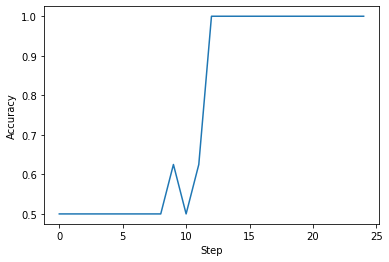

In [18]:
plt.plot(training_steps, accuracy_steps)
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.show()


<h3> References </h3>

<UL>
    <LI>https://pennylane.ai/qml/demos/tutorial_variational_classifier.html</LI>
    <LI>https://covalent.readthedocs.io/en/latest/index.html</LI>
</UL>